In [1]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/mint_cnn_keras.ipynb
import sys, os

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# importing "Skater" related functions
from skater.util.image_ops import load_image, show_image, normalize, noisy
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 61s - loss: 0.3134 - acc: 0.9033 - val_loss: 0.0685 - val_acc: 0.9779
Epoch 2/3
60000/60000 [==============================] - 61s - loss: 0.1049 - acc: 0.9694 - val_loss: 0.0476 - val_acc: 0.9840
Epoch 3/3
60000/60000 [==============================] - 61s - loss: 0.0763 - acc: 0.9767 - val_loss: 0.0400 - val_acc: 0.9869


### Evaluating the model

In [4]:
score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train)
print("Test loss: {}".format(score_test[0]))
print("Train accuracy: {}".format(score_train[1]))
print('Test accuracy:', score_test[1])

59904/60000 [============================>.] - ETA: 0sTest loss: 0.040030641098250636
Train accuracy: 0.9891833333333333
Test accuracy: 0.9869


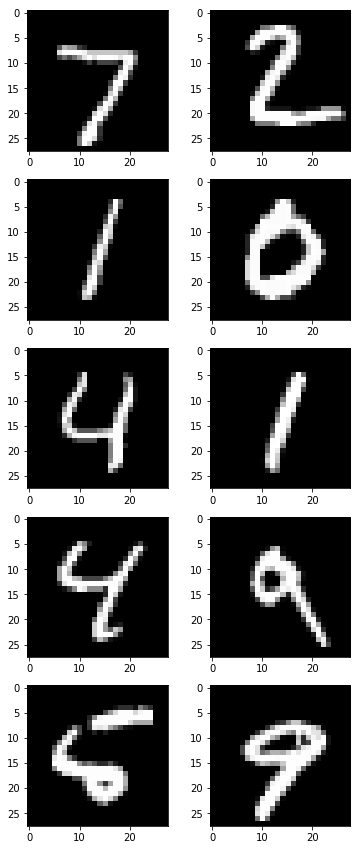

In [51]:
# We can use the first 10 rows to interpret the model performance
import matplotlib.pyplot as plt
%matplotlib inline
xs = x_test[0:10]
ys = y_test[0:10]

n_cols = 2
n_rows = int(len(xs)/2)
plt.figure(figsize=(3*n_cols, 3*n_rows))
for i in range(len(xs)):
    plt.subplot(5, 2, i+1)
    plt.imshow(xs[i].reshape(28,28), cmap='gray')

### Lets ask Skater to help us with interpreting the the above build model

In [44]:
with DeepInterpreter(session=K.get_session()) as di:
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    #print(target_tensor.shape)
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    relevance_scores = di.explain('elrp', target_tensor * ys, input_tensor, xs)

2018-04-06 21:17:02,510 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - all supported relevancy scorers OrderedDict([('elrp', <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>)])
2018-04-06 21:17:02,510 - skater.core.local_interpretation.dnni.deep_interpreter - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>


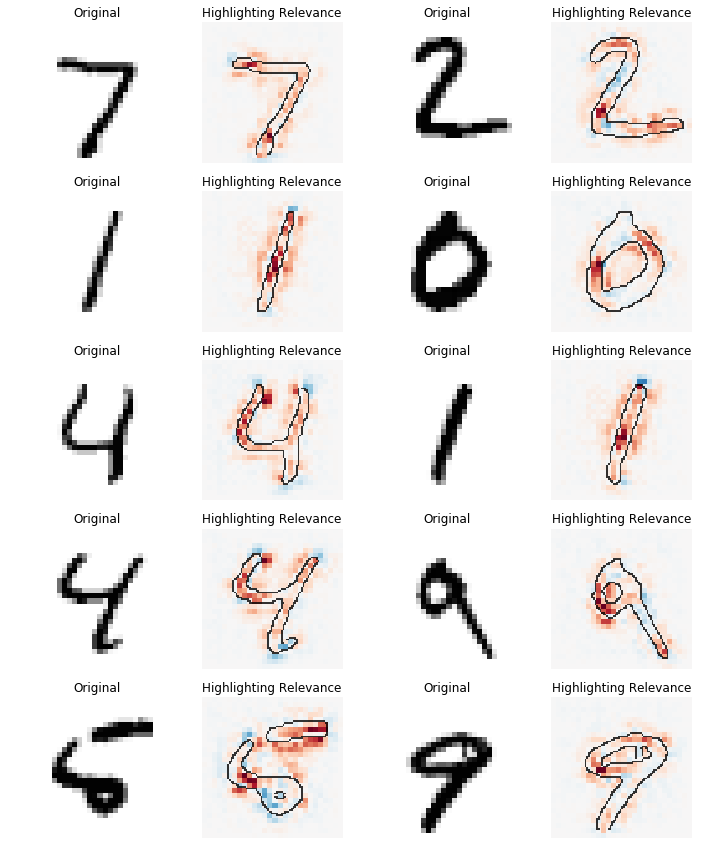

In [52]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = 4
n_rows = int(len(relevance_scores) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(relevance_scores):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Highlighting Relevance')